In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from utils import draw_in_row
from utils import NormalDistribution
from utils import plot_confusion_matrix
from utils import MixtureGaussians

plt.rcParams['figure.figsize'] = (10,6)

np.random.seed(42)

# Cautious classification

Performing cautious classification is a method to predict the classes considering
the option of abstaining to predict any instance, given that the instance seems
ambiguous. In that case, the missclassification could be worst than abstaining
giving the possibility of performing a further analysis of the instance.

For example, lets assume that we have two classes with the following description

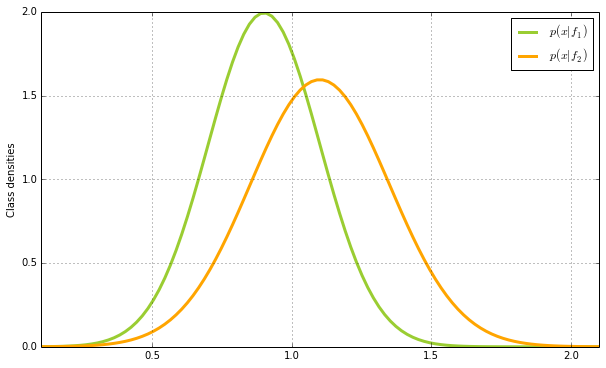

In [2]:
norm_f1 = NormalDistribution(mu=0.9, sigma=0.2)
norm_f2 = NormalDistribution(mu=1.1, sigma=0.25)

p_f1 = 0.4
p_f2 = 0.6

x_min = np.min([norm_f1.mu-4*norm_f1.sigma, norm_f2.mu-4*norm_f2.sigma])
x_max = np.max([norm_f1.mu+4*norm_f1.sigma, norm_f2.mu+4*norm_f2.sigma])

x_lin = np.linspace(x_min, x_max, 100)

p_x_g_f1 = norm_f1.pdf(x_lin)
p_x_g_f2 = norm_f2.pdf(x_lin)

plt.plot(x_lin, p_x_g_f1, color='yellowgreen', label='$p(x|f_1)$', linewidth=3)
plt.plot(x_lin, p_x_g_f2, color='orange', label='$p(x|f_2)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

Then we can compute the posterior probabilities for both classes using Bayes' theorem.

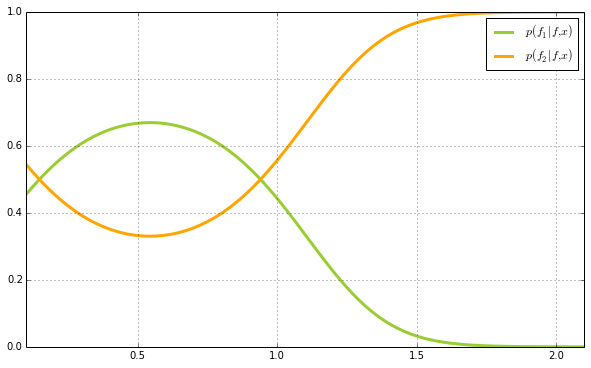

In [3]:
p_x = p_x_g_f1*p_f1 + p_x_g_f2*p_f2

p_f1_g_f_x = (p_x_g_f1*p_f1)/p_x
p_f2_g_f_x = (p_x_g_f2*p_f2)/p_x

plt.plot(x_lin, p_f1_g_f_x, color='yellowgreen', label='$p(f_1|f, x)$', linewidth=3)
plt.plot(x_lin, p_f2_g_f_x, color='orange', label='$p(f_2|f, x)$', linewidth=3)
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

# Chow's rule

Chow's rule states that it is possible to make cautious classifications by 
rejecting the predictions for which the posterior probabilites for the instance
$x$ are

$$ \forall_i,p(y=i|x) < \theta $$

We can visualize this with the posterior probabilities and we can see that this
corresponds to reject the regions of the input space where the posterior probabilites
are really similar.

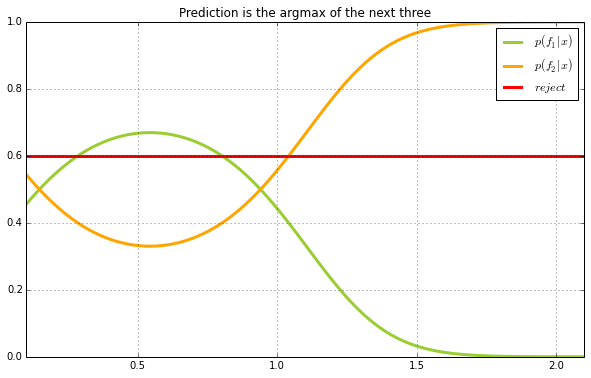

In [4]:
p_x = p_x_g_f1*p_f1 + p_x_g_f2*p_f2

p_f1_g_f_x = (p_x_g_f1*p_f1)/p_x
p_f2_g_f_x = (p_x_g_f2*p_f2)/p_x

theta = 0.6

def plot_predictions(x, f1, f2, reject):
    plt.plot(x, f1, color='yellowgreen', label=r'$p(f_1|x)$', linewidth=3)
    plt.plot(x, f2, color='orange', label=r'$p(f_2|x)$', linewidth=3)
    plt.plot(x, reject, color='red', label=r'$reject$', linewidth=3)
    plt.legend()
    plt.xlim([x.min(), x.max()])
    plt.grid(True)
    plt.title("Prediction is the argmax of the next three")

reject = np.ones_like(x_lin)*theta
plot_predictions(x_lin, p_f1_g_f_x, p_f2_g_f_x, reject)

# C. Ferri and J. Hernández Orallo

Another option is to have one thershold $\theta$ per class. Then, if the posterior probability
of one class is lower than its corresponding threshold then the models abstains.

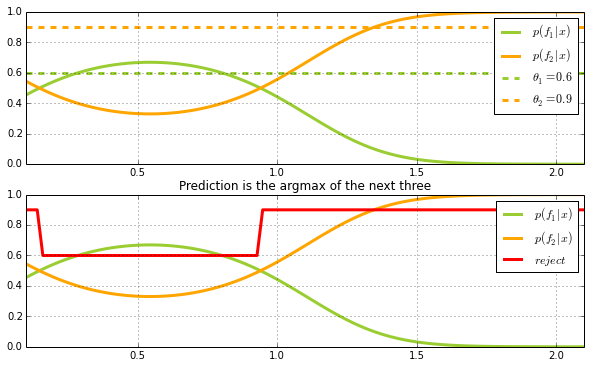

In [5]:
theta_f1 = 0.6
theta_f2 = 0.9
thetas = np.array([theta_f1, theta_f2])

def plot_original_thresholds(x, f1, f2, theta1, theta2):
    plt.plot(x, f1, color='yellowgreen', label=r'$p(f_1|x)$', linewidth=3)
    plt.plot(x, f2, color='orange', label=r'$p(f_2|x)$', linewidth=3)
    plt.plot(x, np.ones_like(x)*theta1, '--', color='yellowgreen', label=r"$\theta_1 = {}$".format(theta1), linewidth=3)
    plt.plot(x, np.ones_like(x)*theta2, '--', color='orange', label=r"$\theta_2 = {}$".format(theta2), linewidth=3)

    plt.legend()
    plt.xlim([x.min(), x.max()])
    plt.grid(True)

plt.subplot(2,1,1)
plot_original_thresholds(x_lin, p_f1_g_f_x, p_f2_g_f_x, theta_f1, theta_f2)

c = np.argmax(np.vstack((p_f1_g_f_x, p_f2_g_f_x)), axis=0)
reject = thetas[c]

plt.subplot(2,1,2)
plot_predictions(x_lin, p_f1_g_f_x, p_f2_g_f_x, reject)

However with imbalanced classes this method can be problematic as some of the classes could have really low probabilities. For that reason the same authors proposed the use of scaled probabilities with respect to their corresponding thresholds.

If $\exists p_i, p_i \ge \theta_i$ then class = argmax$_i(p_i / \theta_i)$

Else class = abstain

## TODO modify this example

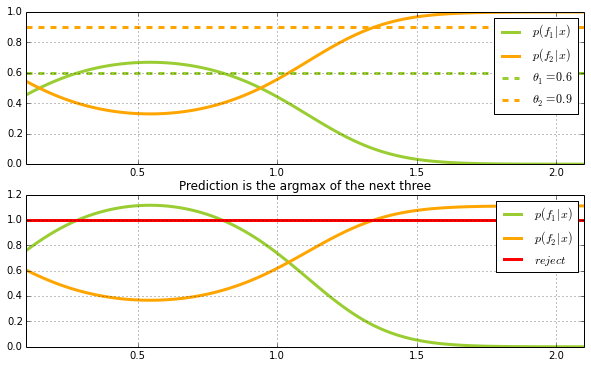

In [6]:
plt.subplot(2,1,1)
plot_original_thresholds(x_lin, p_f1_g_f_x, p_f2_g_f_x, theta_f1, theta_f2)

reject = np.ones_like(x_lin)

plt.subplot(2,1,2)
plot_predictions(x_lin, p_f1_g_f_x/theta_f1, p_f2_g_f_x/theta_f2, reject)

However, the previous approach is merging two different aspects in the thresholds:

1. The relevance of each class, given the differences between the thresholds
2. The degree of abstention, given by the size of the thresholds

Using the previous method, in order to decrease the abstention all the thresholds need to
be decreased in the same proportion. In order to avoid that, it is possible to make the
class biases to sum to one and then separate both aspects.

Define the Class Bias $K = {k_i}$ for $i \in {1,\dots |C|}$, where $\sum_i k_i = 1$ and a window
size $w$, $0\ge w \ge 1$.

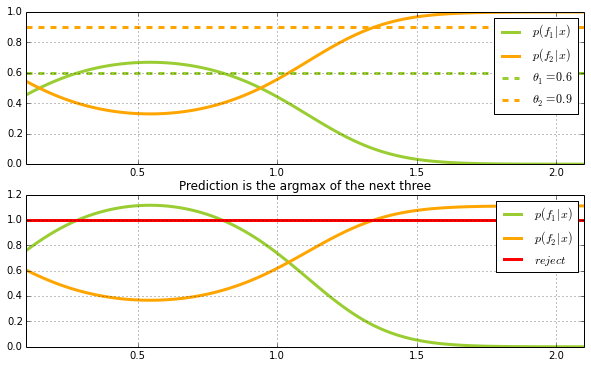

In [7]:
k_f1 = 0.2
k_f2 = 0.8
w = 0.5

theta_f1 = (1-k_f1)*w + k_f1
theta_f2 = (1-k_f2)*w + k_f2
thetas = np.array([theta_f1, theta_f2])

plt.subplot(2,1,1)
plot_original_thresholds(x_lin, p_f1_g_f_x, p_f2_g_f_x, theta_f1, theta_f2)

reject = np.ones_like(x_lin)

plt.subplot(2,1,2)
plot_predictions(x_lin, p_f1_g_f_x/theta_f1, p_f2_g_f_x/theta_f2, reject)

## Background Check

It is possible to solve the same task by assuming that there exist a _background_ class with the same distribution as the _foreground_ but with a different prior probability. In this case, regions where the probabilities for all the _foreground_ classes are lower than the _background_ probability is considered as an uncertain region and can be rejected.

We achieve this behaviour by using the affine inductive bias

$$ q_b(x) = (1-q_f(x))\mu(0) + q_f(x)\mu(1)$$

were in this particular case $\mu(0) = 0$ and $\mu(1) = \theta$.

Then 

$$ q_b(x) = q_f(x)\theta $$

This means that the ratio between the two distributions is qual to the inverse of the threshold $\theta$

$$ \frac{q_f(x)}{q_b(x)} = \theta^{-1} = r(x) $$

thus

$$
p(b|x) = \frac{1}{1+\theta^{-1}} \\
p(f_c|x) = \frac{p(f_c|f,x)\theta^{-1}}{1+\theta^{-1}}
$$

Because of this parametrization, the density of the _foreground_ and the _background_ are not important as they cancel each other and what it remains is their ratio. For that reason in the next examples we arebitrarly assigned to the _foreground_ a fixed constant distribution with the value 1.

(0, 1)

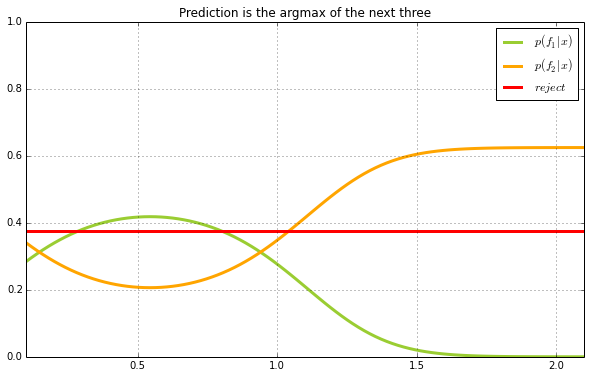

In [8]:
p_f_x = 1
mu0 = 0
mu1 = 0.6
theta = mu1

p_b_x = np.ones_like(x_lin)*1/(1 + theta**-1)

p_f1_g_x = (p_f1_g_f_x*theta**-1)/(1+theta**-1)
p_f2_g_x = (p_f2_g_f_x*theta**-1)/(1+theta**-1)

plot_predictions(x_lin, p_f1_g_x, p_f2_g_x, p_b_x)
plt.ylim([0,1])

The same can be done with multiple thresholds as explained by C. Ferri and J. Hernàndez Orallo by setting a __background check__ per class.


$$
q_{bf_1}(x) = q_{f_1}(x)\theta_1 \\
q_{bf_2}(x) = q_{f_2}(x)\theta_2
$$

## TODO create example with various thresholds (one per class)

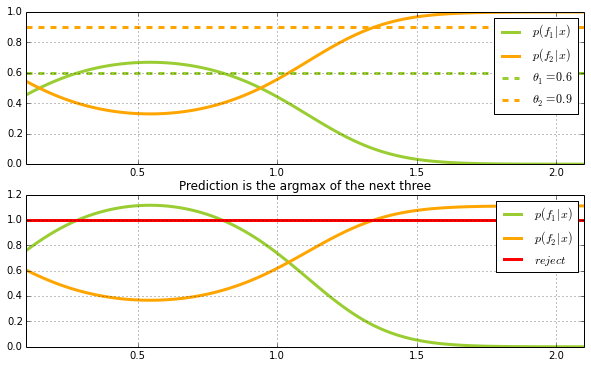

In [9]:
k_f1 = 0.2
k_f2 = 0.8
w = 0.5

theta_f1 = (1-k_f1)*w + k_f1
theta_f2 = (1-k_f2)*w + k_f2
thetas = np.array([theta_f1, theta_f2])

p_f_x = 1
mu0 = 0
mu1 = theta_f1
p_b_f1_x = np.ones_like(x_lin)*((1-p_f1_g_f_x)*mu0 + p_f1_g_f_x*mu1)

mu1 = theta_f1
p_b_f1_x = np.ones_like(x_lin)*((1-p_f1_g_f_x)*mu0 + p_f1_g_f_x*mu1)

plt.subplot(2,1,1)
plot_original_thresholds(x_lin, p_f1_g_f_x, p_f2_g_f_x, theta_f1, theta_f2)

reject = np.ones_like(x_lin)

plt.subplot(2,1,2)
plot_predictions(x_lin, p_f1_g_f_x/theta_f1, p_f2_g_f_x/theta_f2, reject)